In [1]:
import pandas as pd
import os
import re
import numpy as np
import klib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D, Conv1D, MaxPooling1D

# from keras.utils import to_categorical
# from keras.optimizers import SGD 
# from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
# import itertools

Attribute Information:
1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


In [4]:
df = pd.read_csv("household_power_consumption.txt", sep=";", low_memory=False)

In [5]:
df.shape

(2075259, 9)

In [6]:
df['Datetime'] = df['Date'] +" "+df['Time']
df = df.replace({"?":np.nan})
df['Datetime'] = pd.to_datetime(df.Datetime, format='%d/%m/%Y %H:%M:%S')
df.drop(["Date", "Time"], axis=1, inplace=True)

In [7]:
lst = df.columns.to_list()
lst.remove("Datetime")

In [8]:
df.dtypes

Global_active_power              object
Global_reactive_power            object
Voltage                          object
Global_intensity                 object
Sub_metering_1                   object
Sub_metering_2                   object
Sub_metering_3                  float64
Datetime                 datetime64[ns]
dtype: object

In [9]:
for col in lst:
    df[col] = df[col].astype(float)

In [10]:
for col in list(df.columns):
    print(df[col].isna().sum())

25979
25979
25979
25979
25979
25979
25979
0


In [11]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [12]:
df = df.set_index("Datetime")

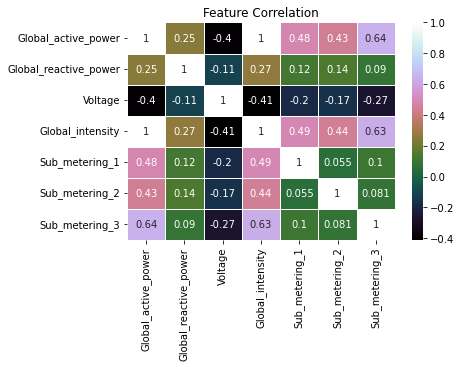

In [13]:
sns.heatmap(df.corr(), annot = True, linewidths=.5, cmap="cubehelix")
plt.title("Feature Correlation")
plt.show()

In [17]:
df_resample_hour = df.resample('h').mean()
df_resample_day = df.resample('D').mean()
df_resample_month = df.resample('M').mean()

In [18]:
for df in [df_resample_hour, df_resample_day,df_resample_month]:
    print("Dataframe missing values per column: ")
    for col in list(df.columns):
        print(df[col].isna().sum())
    print("----------------------------------------------------------------------------")

Dataframe missing values per column: 
421
421
421
421
421
421
421
----------------------------------------------------------------------------
Dataframe missing values per column: 
9
9
9
9
9
9
9
----------------------------------------------------------------------------
Dataframe missing values per column: 
0
0
0
0
0
0
0
----------------------------------------------------------------------------


In [20]:
for df in [df_resample_hour, df_resample_day,df_resample_month]:
    for col in list(df.columns):
        df[col] = df[col].fillna(df[col].mean())

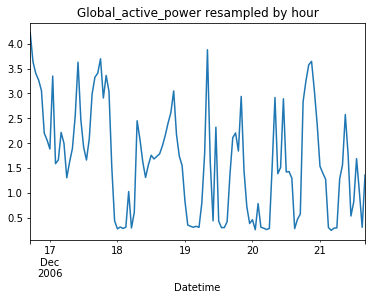

In [21]:
df_resample_hour.Global_active_power[:120].plot(title='Global_active_power resampled by hour') 
plt.show()

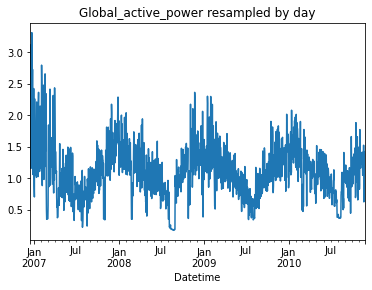

In [22]:
df_resample_day.Global_active_power.plot(title='Global_active_power resampled by day') 
plt.show()

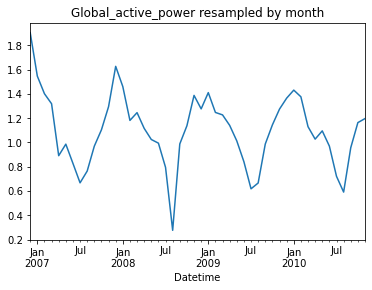

In [23]:
df_resample_month.Global_active_power.plot(title='Global_active_power resampled by month') 
plt.show()

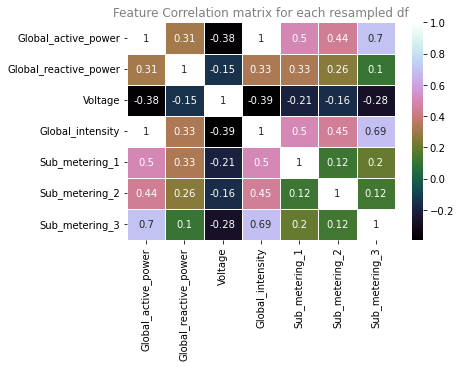

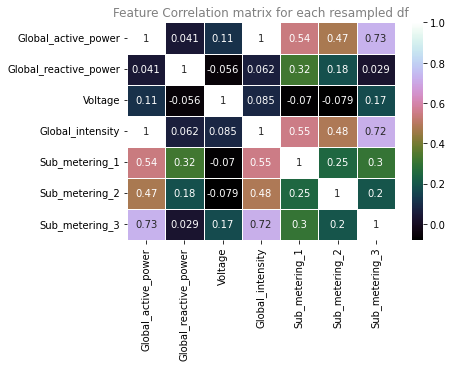

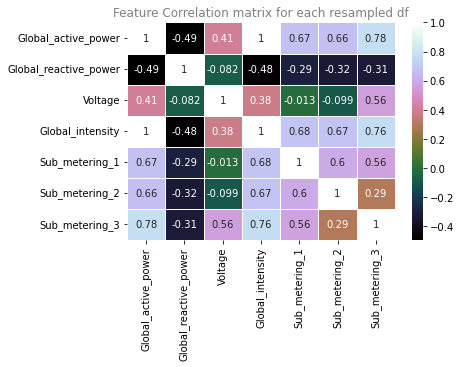

In [24]:
for i, df in enumerate([df_resample_hour, df_resample_day,df_resample_month]):
    plt.figure(i)
    sns.heatmap(df.corr(), annot = True, linewidths=.5, cmap="cubehelix")

    plt.title("Feature Correlation matrix for each resampled df", fontdict={"color":"grey"})
    plt.show()

In [25]:
features = df_resample_hour.drop(["Global_active_power"], axis=1)
target = df_resample_hour["Global_active_power"]

In [26]:
df_resample_hour

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


In [27]:
train_X, test_X, train_y, test_y = train_test_split(features, target, test_size = 0.25, random_state = 42)
val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, test_size = 0.33, random_state = 42)

print(train_X.shape)
print(train_y.shape)

print(val_X.shape)
print(val_y.shape)

print(test_X.shape)
print(test_y.shape)

(25941, 6)
(25941,)
(5794, 6)
(5794,)
(2854, 6)
(2854,)


In [28]:
mm = MinMaxScaler(feature_range=(0, 1))
train_X = mm.fit_transform(train_X)
val_X = mm.transform(val_X)
test_X = mm.transform(test_X)

In [259]:
# values = df_resample_hour.values 
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

# # split into train and test sets

# n_train_time = 365*24
# train = scaled[:n_train_time, :]
# test = scaled[n_train_time:, :]

In [29]:
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape) 


(25941, 1, 6) (25941,) (5794, 1, 6) (5794,) (2854, 1, 6) (2854,)


Epoch 1/20
371/371 - 8s - loss: 0.3079 - val_loss: 0.0331 - 8s/epoch - 21ms/step
Epoch 2/20
371/371 - 2s - loss: 0.0289 - val_loss: 0.0016 - 2s/epoch - 6ms/step
Epoch 3/20
371/371 - 2s - loss: 0.0187 - val_loss: 0.0011 - 2s/epoch - 6ms/step
Epoch 4/20
371/371 - 2s - loss: 0.0173 - val_loss: 6.9349e-04 - 2s/epoch - 6ms/step
Epoch 5/20
371/371 - 2s - loss: 0.0161 - val_loss: 0.0011 - 2s/epoch - 6ms/step
Epoch 6/20
371/371 - 2s - loss: 0.0156 - val_loss: 6.5633e-04 - 2s/epoch - 6ms/step
Epoch 7/20
371/371 - 2s - loss: 0.0139 - val_loss: 5.2832e-04 - 2s/epoch - 6ms/step
Epoch 8/20
371/371 - 2s - loss: 0.0141 - val_loss: 7.4157e-04 - 2s/epoch - 6ms/step
Epoch 9/20
371/371 - 2s - loss: 0.0125 - val_loss: 0.0011 - 2s/epoch - 6ms/step
Epoch 10/20
371/371 - 2s - loss: 0.0122 - val_loss: 0.0014 - 2s/epoch - 6ms/step
Epoch 11/20
371/371 - 2s - loss: 0.0114 - val_loss: 7.1872e-04 - 2s/epoch - 5ms/step
Epoch 12/20
371/371 - 2s - loss: 0.0108 - val_loss: 5.2630e-04 - 2s/epoch - 5ms/step
Epoch 13/20


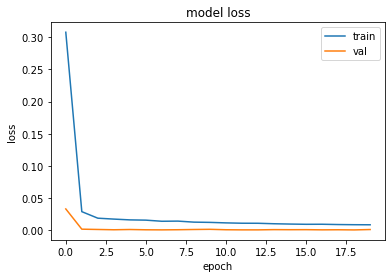

In [30]:
model = Sequential()
model.add(LSTM(100,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(70))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(val_X, val_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [31]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 6))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = mm.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.values.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = mm.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

90/90 [==============================] - 1s 3ms/step
Test RMSE: 0.026


In [32]:
inv_yhat

array([0.29427777, 1.43673099, 0.79788187, ..., 1.66984363, 1.10544983,
       1.13291553])

In [33]:
inv_y

array([0.28905863, 1.44866705, 0.80140919, ..., 1.7034559 , 1.11767273,
       1.14322573])

In [283]:
r2_score(inv_y, inv_yhat)

0.9990828378245118

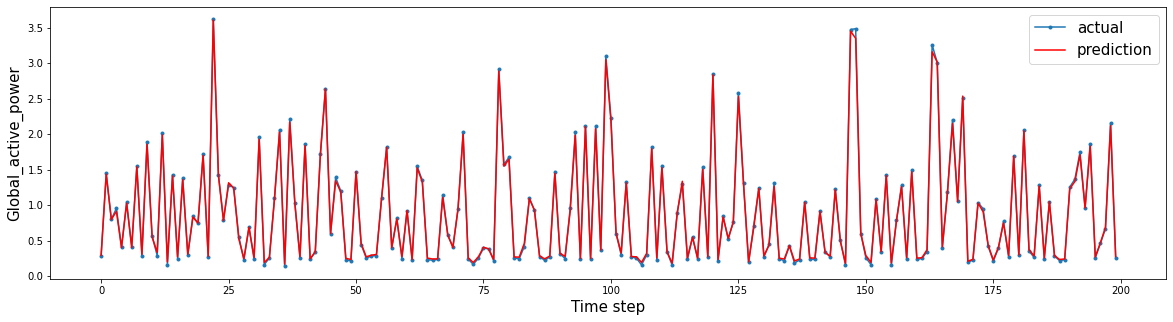

In [39]:
aa=[x for x in range(200)]
plt.figure(figsize=(20,5))
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()